In [11]:
import numpy as np
from typing import Tuple
from google.cloud import storage
from keras import Model, Sequential, layers, regularizers, optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from ai_detector.params import *

In [2]:
from ai_detector.params import BUCKET_NAME

# Functions

## Load Data

In [63]:
def load_data(max_results):

    storage_client = storage.Client(project=GCP_PROJECT)

    X = []
    y = []

    blobbe_fake = storage_client.list_blobs(BUCKET_NAME_FAKE, max_results=max_results)#, prefix="/Train/fake/")

    for blob in blobbe_fake:
        string_out = blob.download_as_bytes()
        array_tensor = tf.convert_to_tensor(string_out)
        good_array = tf.io.decode_image(array_tensor)
        if good_array.shape[-1] == 1:
            good_array = tf.image.grayscale_to_rgb(good_array)
        good_array = tf.image.resize(good_array,[128,128])
        X.append(good_array)
        y.append(1)

    blobbe_real = storage_client.list_blobs(BUCKET_NAME_REAL, max_results=max_results)#, prefix="/Train/real/")

    for blob in blobbe_real:
        string_out = blob.download_as_bytes()
        array_tensor = tf.convert_to_tensor(string_out)
        good_array = tf.io.decode_image(array_tensor)
        if good_array.shape[-1] == 1:
            good_array = tf.image.grayscale_to_rgb(good_array)
        good_array = tf.image.resize(good_array,[128,128])
        X.append(good_array)
        y.append(0)

    X = np.array(X)
    y = np.array(y)

    return X, y

## Initialize Model

In [4]:
def initialize_model(input_shape):

    model = Sequential()

    model.add(layers.Conv2D(32, (3,3), input_shape=input_shape, activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, (3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(128, (3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(256, (3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(512, activation='relu'))

    model.add(layers.Dense(256, activation='relu'))

    model.add(layers.Dense(1, activation='sigmoid'))

    return model

## Compile Model

In [5]:
def model_compile(model):
    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy']
                )
    return model

## Plot

In [6]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    plt.show();
    return (ax1, ax2)

# Playground

### 1. Load Data

In [64]:
max_results = 5000

X, y = load_data(max_results)

In [61]:
X

array([], dtype=float64)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### 2. Initialize, train model & Plot

#### Test 1 - 84.04%

Epoch 1/75
40/40 [==============================] - 6s 137ms/step - loss: 10.2038 - accuracy: 0.5156 - val_loss: 0.6917 - val_accuracy: 0.5234
Epoch 2/75
40/40 [==============================] - 5s 133ms/step - loss: 0.6827 - accuracy: 0.5508 - val_loss: 0.6718 - val_accuracy: 0.5033
Epoch 3/75
40/40 [==============================] - 5s 129ms/step - loss: 0.6725 - accuracy: 0.6016 - val_loss: 0.6332 - val_accuracy: 0.6406
Epoch 4/75
40/40 [==============================] - 5s 131ms/step - loss: 0.6569 - accuracy: 0.6289 - val_loss: 0.6953 - val_accuracy: 0.5792
Epoch 5/75
40/40 [==============================] - 5s 135ms/step - loss: 0.6277 - accuracy: 0.6852 - val_loss: 0.6901 - val_accuracy: 0.5781
Epoch 6/75
40/40 [==============================] - 5s 133ms/step - loss: 0.5922 - accuracy: 0.6889 - val_loss: 0.7706 - val_accuracy: 0.6228
Epoch 7/75
40/40 [==============================] - 5s 133ms/step - loss: 0.6080 - accuracy: 0.6812 - val_loss: 0.5219 - val_accuracy: 0.7299
Epoch

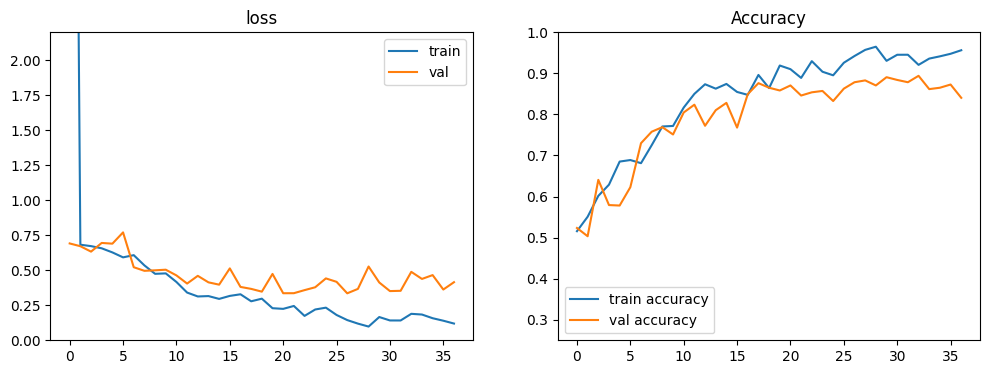

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

In [26]:
input_shape = (128, 128, 3)

model = initialize_model(input_shape)
model = model_compile(model)

epochs = 75
steps_per_epoch = 40
batch_size = 32
patience = 10
validation_data = (X_val, y_val)
validation_steps=28
verbose = 1
#filepath ="/Users/alexisdraguet/code/Corentr1/Model"

es = EarlyStopping(
    patience=patience,
    restore_best_weights=True,
    verbose=verbose)

history = model.fit(
    X_train,
    y_train,
    validation_data=validation_data,
    validation_steps=validation_steps,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    batch_size=batch_size,
    callbacks=[es],#, cp],
    verbose=verbose
    )

plot_history(history)

#### Test 2 - 86.79%

Epoch 1/75
40/40 [==============================] - 7s 177ms/step - loss: 9.8348 - accuracy: 0.5256 - val_loss: 0.6832 - val_accuracy: 0.5321
Epoch 2/75
40/40 [==============================] - 7s 170ms/step - loss: 0.6833 - accuracy: 0.5606 - val_loss: 0.6804 - val_accuracy: 0.5482
Epoch 3/75
40/40 [==============================] - 7s 164ms/step - loss: 0.6826 - accuracy: 0.5677 - val_loss: 0.6768 - val_accuracy: 0.5652
Epoch 4/75
40/40 [==============================] - 6s 163ms/step - loss: 0.6855 - accuracy: 0.5587 - val_loss: 0.6865 - val_accuracy: 0.5250
Epoch 5/75
40/40 [==============================] - 7s 166ms/step - loss: 0.6588 - accuracy: 0.5975 - val_loss: 0.5846 - val_accuracy: 0.6768
Epoch 6/75
40/40 [==============================] - 7s 167ms/step - loss: 0.6025 - accuracy: 0.6775 - val_loss: 0.5349 - val_accuracy: 0.7357
Epoch 7/75
40/40 [==============================] - 7s 163ms/step - loss: 0.6030 - accuracy: 0.6715 - val_loss: 0.5211 - val_accuracy: 0.7384
Epoch 

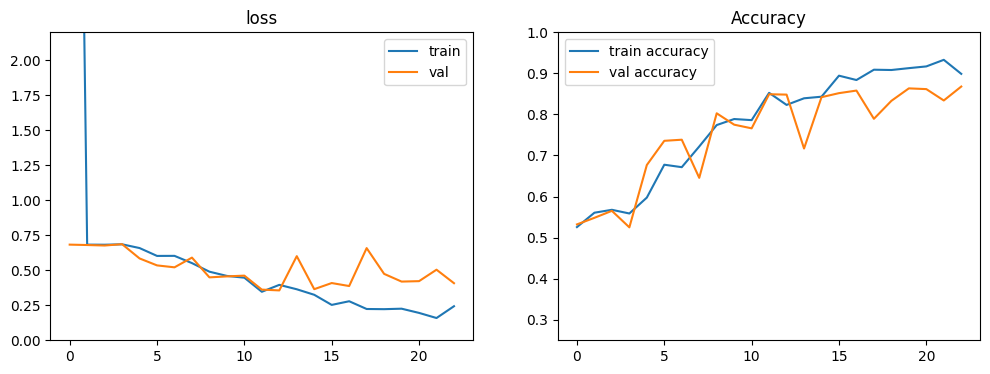

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

In [29]:
input_shape = (128, 128, 3)

model = initialize_model(input_shape)
model = model_compile(model)

epochs = 75
steps_per_epoch = 40
batch_size = 40
patience = 10
validation_data = (X_val, y_val)
validation_steps=28
verbose = 1
#filepath ="/Users/alexisdraguet/code/Corentr1/Model"

es = EarlyStopping(
    patience=patience,
    restore_best_weights=True,
    verbose=verbose)

history = model.fit(
    X_train,
    y_train,
    validation_data=validation_data,
    validation_steps=validation_steps,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    batch_size=batch_size,
    callbacks=[es],#, cp],
    verbose=verbose
    )

plot_history(history)

#### Test 3 - 86.00%

Epoch 1/75
40/40 [==============================] - 8s 186ms/step - loss: 6.3987 - accuracy: 0.5512 - val_loss: 0.6713 - val_accuracy: 0.6275
Epoch 2/75
40/40 [==============================] - 6s 158ms/step - loss: 0.6714 - accuracy: 0.5869 - val_loss: 0.6781 - val_accuracy: 0.6075
Epoch 3/75
40/40 [==============================] - 6s 154ms/step - loss: 0.6743 - accuracy: 0.6158 - val_loss: 0.6571 - val_accuracy: 0.6212
Epoch 4/75
40/40 [==============================] - 6s 156ms/step - loss: 0.6525 - accuracy: 0.6062 - val_loss: 0.6819 - val_accuracy: 0.5275
Epoch 5/75
40/40 [==============================] - 6s 156ms/step - loss: 0.6125 - accuracy: 0.6684 - val_loss: 0.5844 - val_accuracy: 0.6750
Epoch 6/75
40/40 [==============================] - 6s 155ms/step - loss: 0.5713 - accuracy: 0.6969 - val_loss: 0.5129 - val_accuracy: 0.7437
Epoch 7/75
40/40 [==============================] - 6s 152ms/step - loss: 0.5215 - accuracy: 0.7297 - val_loss: 0.5019 - val_accuracy: 0.7525
Epoch 

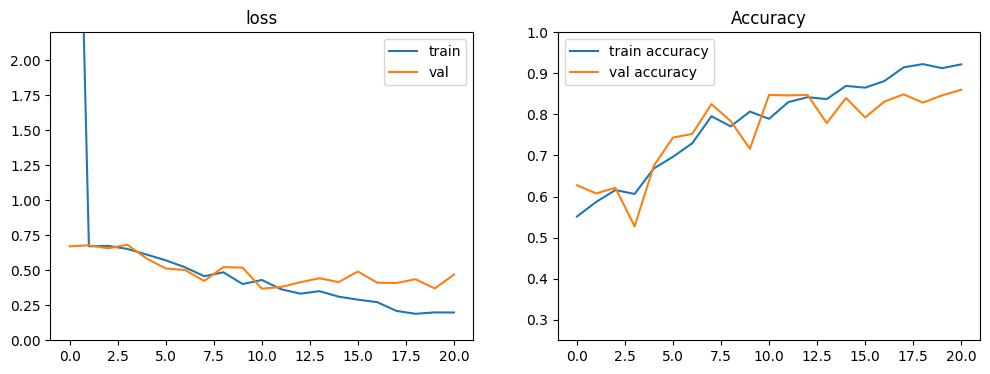

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

In [33]:
input_shape = (128, 128, 3)

model = initialize_model(input_shape)
model = model_compile(model)

epochs = 75
steps_per_epoch = 40
batch_size = 40
patience = 10
validation_data = (X_val, y_val)
validation_steps=20
verbose = 1
#filepath ="/Users/alexisdraguet/code/Corentr1/Model"

es = EarlyStopping(
    patience=patience,
    restore_best_weights=True,
    verbose=verbose)

history = model.fit(
    X_train,
    y_train,
    validation_data=validation_data,
    validation_steps=validation_steps,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    batch_size=batch_size,
    callbacks=[es],#, cp],
    verbose=verbose
    )

plot_history(history)

#### Test 4 - 83.28%

Epoch 1/75
40/40 [==============================] - 7s 175ms/step - loss: 5.6356 - accuracy: 0.5106 - val_loss: 0.6855 - val_accuracy: 0.5836
Epoch 2/75
40/40 [==============================] - 7s 170ms/step - loss: 0.6876 - accuracy: 0.5838 - val_loss: 0.6879 - val_accuracy: 0.5320
Epoch 3/75
40/40 [==============================] - 7s 167ms/step - loss: 0.6787 - accuracy: 0.5759 - val_loss: 0.6855 - val_accuracy: 0.5648
Epoch 4/75
40/40 [==============================] - 7s 169ms/step - loss: 0.6684 - accuracy: 0.6075 - val_loss: 0.6724 - val_accuracy: 0.6086
Epoch 5/75
40/40 [==============================] - 7s 167ms/step - loss: 0.6669 - accuracy: 0.6196 - val_loss: 0.6850 - val_accuracy: 0.5391
Epoch 6/75
40/40 [==============================] - 7s 170ms/step - loss: 0.6721 - accuracy: 0.5869 - val_loss: 0.6837 - val_accuracy: 0.5609
Epoch 7/75
40/40 [==============================] - 7s 169ms/step - loss: 0.6553 - accuracy: 0.6234 - val_loss: 0.6291 - val_accuracy: 0.6492
Epoch 

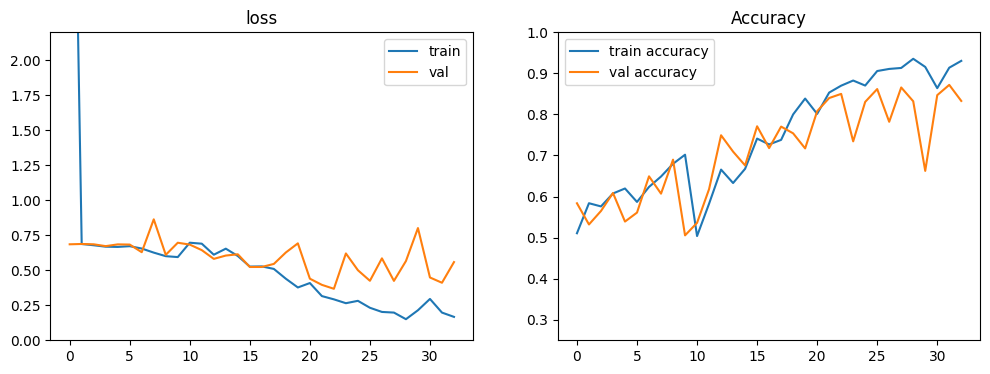

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

In [35]:
input_shape = (128, 128, 3)

model = initialize_model(input_shape)
model = model_compile(model)

epochs = 75
steps_per_epoch = 40
batch_size = 40
patience = 10
validation_data = (X_val, y_val)
validation_steps=30
verbose = 1
#filepath ="/Users/alexisdraguet/code/Corentr1/Model"

es = EarlyStopping(
    patience=patience,
    restore_best_weights=True,
    verbose=verbose)

history = model.fit(
    X_train,
    y_train,
    validation_data=validation_data,
    validation_steps=validation_steps,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    batch_size=batch_size,
    callbacks=[es],#, cp],
    verbose=verbose
    )

plot_history(history)

#### Test 5 - 60.000 données

In [ ]:
input_shape = (128, 128, 3)

model = initialize_model(input_shape)
model = model_compile(model)

epochs = 75
steps_per_epoch = 40
batch_size = 40
patience = 10
validation_data = (X_val, y_val)
validation_steps=30
verbose = 1
#filepath ="/Users/alexisdraguet/code/Corentr1/Model"

es = EarlyStopping(
    patience=patience,
    restore_best_weights=True,
    verbose=verbose)

history = model.fit(
    X_train,
    y_train,
    validation_data=validation_data,
    validation_steps=validation_steps,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    batch_size=batch_size,
    callbacks=[es],#, cp],
    verbose=verbose
    )

plot_history(history)